# Tutorial for working with the DESI MWS VAC DR1

Here we briefly demonstrate how to use the Milky Way Survey (MWS) Value Added Catalogue (VAC) for 
DESI Data Release 1.

The data that will be used here can be downloaded from: 
https://data.desi.lbl.gov/public/dr1/vac/dr1/mws/iron

The overall description of the MWS VAC is given here:
https://data.desi.lbl.gov/doc/releases/dr1/vac/mws/

And the data-model is available here:
https://desi-mws-dr1-datamodel.readthedocs.io/


This repo has a bash file that downloads the fits files used for this tutorial. 

In this tutorial we will use the combined file 
`mwsall-pix-iron.fits` which has all the MWS information for all the sources in analysed by the MWS pipelines, as well as Gaia 
DR3 xmatch and DESI targeting information.

the individual survey/program files: 
`rvpix-main-bright.fits` -- these are the measurements by the RV pipeline of the soures in the main program, bright survey.
`sppix-main-bright.fits` -- these are the measurements by the SP pipeline of the soures in the main program, bright survey


And individual exposures table
`rvpix_exp-sv3-bright.fits` -- these are the measurements by the RV pipeline from individual DESI exposures for the sv3 survey, bright program

And some individual files for stars in a given healpixel:
`rvtab_coadd-main-bright-10813.fits` -- this a table of measurements by the RV pipeline for sour
`rvmod_coadd-main-bright-10813.fits`




In [1]:
import astropy.table as atpy
import astropy.io.fits as pyfits

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as maco

%matplotlib inline

# Main catalogue

Here we read the combined table that most of the infromation. 
This table consists from several extensions that contain different information

1) RVTAB extension: RVSpecfit pipeline
2) SPTAB extension: FERRE pipeline
3) GAIA extension: Gaia parameters
4) FIBERMAP extension: table of targeting information
5) SCORES extension: spectra quality columns



In [2]:
# Note these are pretty big tables
RV_T = atpy.Table().read('data/mwsall-pix-iron.fits',
                         'RVTAB',
                         mask_invalid=False)
SP_T = atpy.Table().read('data/mwsall-pix-iron.fits',
                         'SPTAB',
                         mask_invalid=False)
FM_T = atpy.Table().read('data/mwsall-pix-iron.fits',
                         'FIBERMAP',
                         mask_invalid=False)
SC_T = atpy.Table().read('data/mwsall-pix-iron.fits',
                         'SCORES',
                         mask_invalid=False)

# Reading the Gaia xmatch 

Since the Gaia cross-match table has all the Gaia columns, 
you may run ouf of memory, so we don't read it as an astropy table, 

In [3]:
# G_T = atpy.Table().read('data/mwsall-pix-iron.fits',
#                        'GAIA',
#                        mask_invalid=False)
G_T = pyfits.getdata('data/mwsall-pix-iron.fits', 'GAIA')

# Selecting sources
Here we identify the sources subset that are 

1) primary (i.e. the best observation if the object was observed in more than one survey/program
2) have no RVS warning flags
3) are classified as star by redrock

In [4]:
main_sel = RV_T['PRIMARY'] & (RV_T['RVS_WARN'] == 0) & (RV_T['RR_SPECTYPE']
                                                        == 'STAR')

# Sky distribution

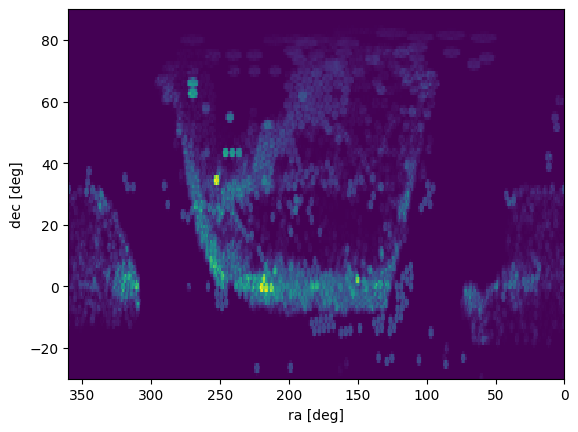

In [5]:
plt.hist2d(RV_T['TARGET_RA'][main_sel],
           RV_T['TARGET_DEC'][main_sel],
           bins=[360, 120],
           range=[[0, 360], [-30, 90]])
plt.xlabel('ra [deg]')
plt.xlim(360, 0)
plt.ylabel('dec [deg]');

# Multiple surveys/programs

The catalogue consists measurements from multiple surveys/programs.

The main survey with the most stars are survey main, program bright and backup.
But there are some stars observed in dark program as well.

In [6]:
# Colour-magnitude distribution by survey/program
print('surveys', np.unique(RV_T['SURVEY'][:]))
print('program', np.unique(RV_T['PROGRAM'][:]))

surveys  SURVEY
-------
    cmx
   main
special
    sv1
    sv2
    sv3
program PROGRAM
-------
 backup
 bright
   dark
  other


# Spatial distribution of objects in different surveys, programs

Here we look at several programs, surveys and look at spatial distribution of targets there


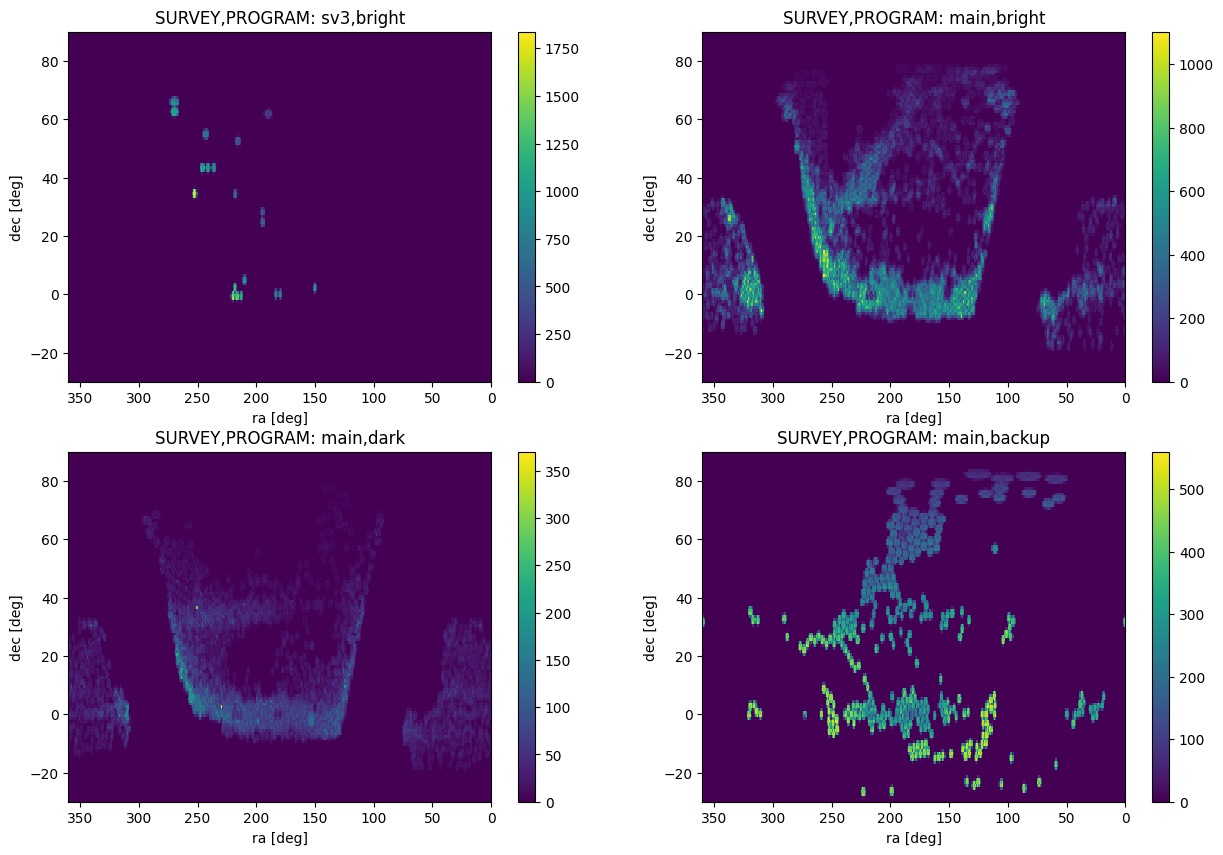

In [7]:
plt.figure(1, figsize=(15,10))
cnt = 0
for survey, program in [('sv3', 'bright'), ('main', 'bright'),
                        ('main', 'dark'), ('main', 'backup')]:
    cur_sel = main_sel & (RV_T['SURVEY'] == survey) & (RV_T['PROGRAM']
                                                       == program)
    plt.subplot(2, 2, cnt + 1)
    plt.hist2d(RV_T['TARGET_RA'][cur_sel],
               RV_T['TARGET_DEC'][cur_sel],
               bins=[360, 120],
               range=[[0, 360], [-30, 90]])
    cnt += 1
    plt.title(f'SURVEY,PROGRAM: {survey},{program}')
    plt.xlabel('ra [deg]')
    plt.xlim(360, 0)
    plt.ylabel('dec [deg]');
    plt.colorbar()


# Photometry, targeting information

So far we mostly used the RVTAB extension, which has some basic source information as well 
as radial velocity and stellar parameters info from RV pipeline. 

If you need photometry and/or targeting infromation, it is mostly in the FIBERMAP extension.

Note that backup program of the main survey was *not* targeted using DESI/DECaLS(legacy) survey, 
therefore it does not have the DECALS flux columns populated. 
For all the rest we can use the FLUX_G,FLUX_R,FLUX_Z sources which are fluxes in g,r,z filters in 
nano-maggies (so they can b converted to magnitudes using 22.5-2.5*log10(flux))

You can see a description of columns in that extension here 
https://desi-mws-dr1-datamodel.readthedocs.io/en/latest/mwsall.html#hdu3


The columns in the fibermap extension:
<TableColumns names=('TARGETID','COADD_FIBERSTATUS','TARGET_RA','TARGET_DEC','PMRA','PMDEC','REF_EPOCH','FA_TARGET','FA_TYPE','OBJTYPE','SUBPRIORITY','OBSCONDITIONS','RELEASE','BRICKNAME','BRICKID','BRICK_OBJID','MORPHTYPE','EBV','FLUX_G','FLUX_R','FLUX_Z','FLUX_W1','FLUX_W2','FLUX_IVAR_G','FLUX_IVAR_R','FLUX_IVAR_Z','FLUX_IVAR_W1','FLUX_IVAR_W2','FIBERFLUX_G','FIBERFLUX_R','FIBERFLUX_Z','FIBERTOTFLUX_G','FIBERTOTFLUX_R','FIBERTOTFLUX_Z','MASKBITS','SERSIC','SHAPE_R','SHAPE_E1','SHAPE_E2','REF_ID','REF_CAT','GAIA_PHOT_G_MEAN_MAG','GAIA_PHOT_BP_MEAN_MAG','GAIA_PHOT_RP_MEAN_MAG','PARALLAX','PHOTSYS','PRIORITY_INIT','NUMOBS_INIT','CMX_TARGET','DESI_TARGET','BGS_TARGET','MWS_TARGET','PLATE_RA','PLATE_DEC','COADD_NUMEXP','COADD_EXPTIME','COADD_NUMNIGHT','COADD_NUMTILE','MEAN_DELTA_X','RMS_DELTA_X','MEAN_DELTA_Y','RMS_DELTA_Y','MEAN_FIBER_RA','STD_FIBER_RA','MEAN_FIBER_DEC','STD_FIBER_DEC','MEAN_PSF_TO_FIBER_SPECFLUX','SCND_TARGET','SV1_DESI_TARGET','SV

/tmp/ipykernel_1189229/3480544984.py:12: RuntimeWarning: invalid value encountered in divide
  np.log10(FM_T['FLUX_G'][cur_sel] / FM_T['FLUX_R'][cur_sel]),
/tmp/ipykernel_1189229/3480544984.py:12: RuntimeWarning: invalid value encountered in log10
  np.log10(FM_T['FLUX_G'][cur_sel] / FM_T['FLUX_R'][cur_sel]),
/tmp/ipykernel_1189229/3480544984.py:13: RuntimeWarning: divide by zero encountered in log10
  22.5 - 2.5 * np.log10(FM_T['FLUX_R'][cur_sel]),
/tmp/ipykernel_1189229/3480544984.py:12: RuntimeWarning: divide by zero encountered in divide
  np.log10(FM_T['FLUX_G'][cur_sel] / FM_T['FLUX_R'][cur_sel]),
/tmp/ipykernel_1189229/3480544984.py:12: RuntimeWarning: divide by zero encountered in log10
  np.log10(FM_T['FLUX_G'][cur_sel] / FM_T['FLUX_R'][cur_sel]),
/tmp/ipykernel_1189229/3480544984.py:13: RuntimeWarning: invalid value encountered in log10
  22.5 - 2.5 * np.log10(FM_T['FLUX_R'][cur_sel]),


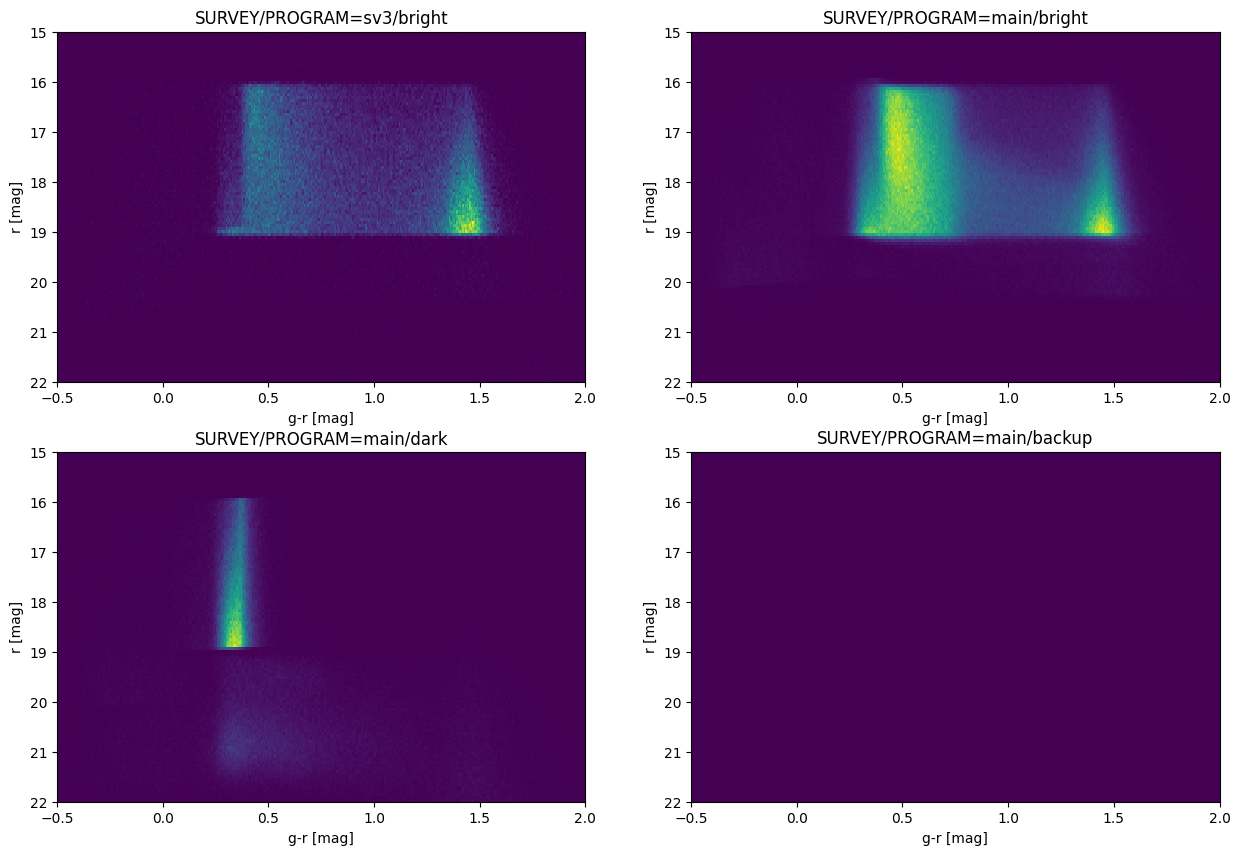

In [8]:
print ('The columns in the fibermap extension:')
print(FM_T.columns)
print('----')
plt.figure(1, figsize=(15, 10))
cnt = 0
for survey, program in [('sv3', 'bright'), ('main', 'bright'),
                        ('main', 'dark'), ('main', 'backup')]:
    cur_sel = main_sel & (RV_T['SURVEY'] == survey) & (RV_T['PROGRAM']
                                                       == program)
    plt.subplot(2, 2, cnt + 1)
    plt.hist2d(-2.5 *
               np.log10(FM_T['FLUX_G'][cur_sel] / FM_T['FLUX_R'][cur_sel]),
               22.5 - 2.5 * np.log10(FM_T['FLUX_R'][cur_sel]),
               bins=[360, 120],
               range=[[-0.5, 2], [15, 22]])
    cnt += 1
    plt.title(f'SURVEY/PROGRAM={survey}/{program}')
    plt.xlabel('g-r [mag]')
    plt.ylim(22, 15)
    plt.ylabel('r [mag]');

# The colour magnitude distribution for backup survey

As mentioned above. The backup survey was targeted using Gaia photometry, and sources there are often brighter than the DECaLS saturation, as well as extend further than the DECaLS footprint. 

Therefore it makes sense to look at backup program sources using Gaia magnitudes.
Gaia magnitudes are stored in the Gaia extension of the table. 

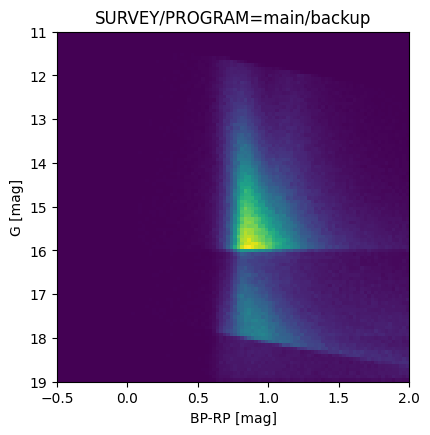

In [9]:
plt.figure(1, figsize=(10,10))
cnt = 0
for survey, program in [('main', 'backup')]:
    cur_sel = main_sel & (RV_T['SURVEY'] == survey) & (RV_T['PROGRAM']
                                                       == program)
    plt.subplot(2, 2, cnt + 1)
    plt.hist2d(G_T['PHOT_BP_MEAN_MAG'][cur_sel] -
               G_T['PHOT_RP_MEAN_MAG'][cur_sel],
               G_T['PHOT_G_MEAN_MAG'][cur_sel],
               bins=[100, 100],
               range=[[-0.5, 2], [11, 19]])
    cnt += 1
    plt.title(f'SURVEY/PROGRAM={survey}/{program}')
    plt.xlabel('BP-RP [mag]')
    plt.ylim(19, 11)
    plt.ylabel('G [mag]');

# Different types of targets 

The targeting information is contained in the DESI_TARGET, MWS_TARGET, BGS_TARGET, SCND_TARGET

The detailed information is elsewhere, but here we show the main MWS object types
(see 
https://github.com/desihub/desitarget/blob/main/py/desitarget/data/targetmask.yaml
also, Koposov et al 2024, Cooper et al 2023, Myers et al 2023)


    - [MWS_BROAD,           0, "Milky Way Survey magnitude limited bulk sample",         {obsconditions: BRIGHT}]
    - [MWS_WD,              1, "Milky Way Survey White Dwarf",                           {obsconditions: BRIGHT|DARK}]
    - [MWS_NEARBY,          2, "Milky Way Survey volume-complete ~100pc sample",         {obsconditions: BRIGHT}]
    #- 6: MWS BHBs
    - [MWS_BHB,             6, "Milky Way Survey Blue Horizontal Branch stars", {obsconditions: BRIGHT|DARK}]

    #- 8: Sub-classes of MWS_MAIN
    - [MWS_MAIN_BLUE,       8, "Milky Way Survey magnitude limited blue sample",              {obsconditions: BRIGHT}]
    - [MWS_MAIN_RED,        11, "Milky Way Survey magnitude limited red sample",              {obsconditions: BRIGHT}]

    # ADM Standard stars based only on Gaia.
    - [GAIA_STD_FAINT,      33, "Standard stars for dark/gray conditions",   {obsconditions: DARK|BACKUP|TWILIGHT12|TWILIGHT18}]
    - [GAIA_STD_WD,         34, "White Dwarf stars",                         {obsconditions: DARK|BRIGHT|BACKUP|TWILIGHT12|TWILIGHT18}]
    - [GAIA_STD_BRIGHT,     35, "Standard stars for BRIGHT conditions",      {obsconditions: BRIGHT|BACKUP|TWILIGHT12|TWILIGHT18}]

/tmp/ipykernel_1189229/2474074659.py:19: RuntimeWarning: divide by zero encountered in divide
  np.log10(FM_T['FLUX_G'][cur_sel] / FM_T['FLUX_R'][cur_sel]),
/tmp/ipykernel_1189229/2474074659.py:19: RuntimeWarning: invalid value encountered in divide
  np.log10(FM_T['FLUX_G'][cur_sel] / FM_T['FLUX_R'][cur_sel]),
/tmp/ipykernel_1189229/2474074659.py:19: RuntimeWarning: divide by zero encountered in log10
  np.log10(FM_T['FLUX_G'][cur_sel] / FM_T['FLUX_R'][cur_sel]),
/tmp/ipykernel_1189229/2474074659.py:20: RuntimeWarning: divide by zero encountered in log10
  22.5 - 2.5 * np.log10(FM_T['FLUX_R'][cur_sel]),
/tmp/ipykernel_1189229/2474074659.py:20: RuntimeWarning: invalid value encountered in log10
  22.5 - 2.5 * np.log10(FM_T['FLUX_R'][cur_sel]),
/tmp/ipykernel_1189229/2474074659.py:19: RuntimeWarning: invalid value encountered in log10
  np.log10(FM_T['FLUX_G'][cur_sel] / FM_T['FLUX_R'][cur_sel]),


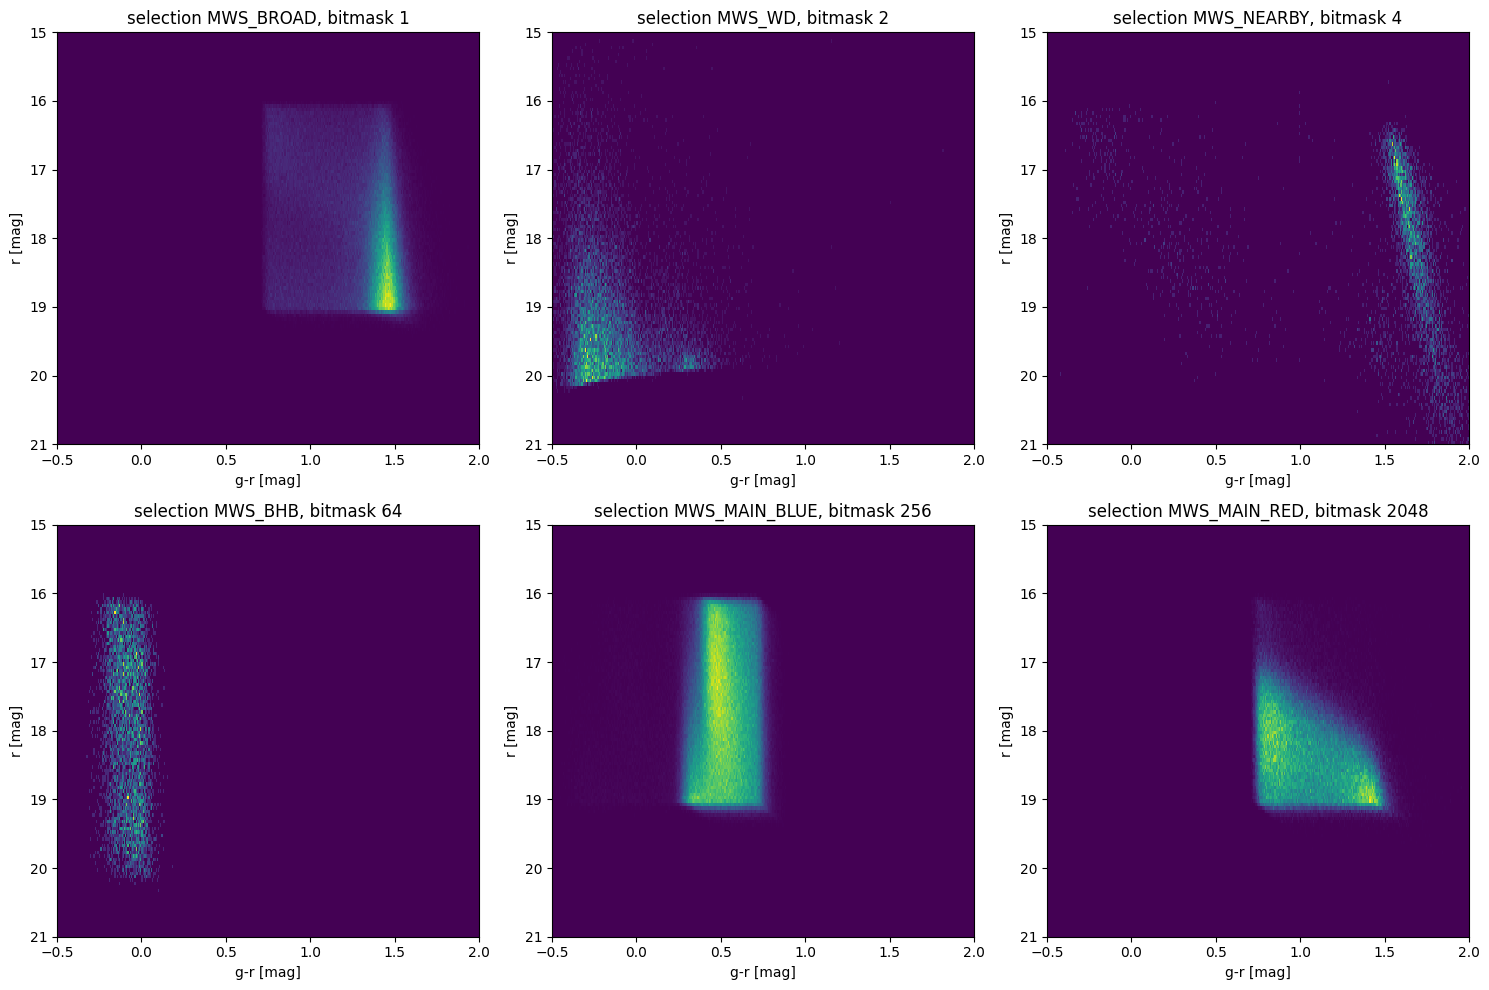

In [10]:
plt.figure(1, figsize=(15, 10))
cnt = 0
bitmasks = {
    'MWS_BROAD': 0,
    'MWS_WD': 1,
    'MWS_NEARBY': 2,
    'MWS_BHB': 6,
    'MWS_MAIN_BLUE': 8,
    'MWS_MAIN_RED': 11
}
survey, program = ('main', 'bright')

for curt, bit in bitmasks.items():
    objtype_sel = (FM_T['MWS_TARGET'] & (2**bit)) > 0
    cur_sel = objtype_sel & main_sel & (RV_T['SURVEY'] == survey) & (
        RV_T['PROGRAM'] == program)
    plt.subplot(2, 3, cnt + 1)
    plt.hist2d(-2.5 *
               np.log10(FM_T['FLUX_G'][cur_sel] / FM_T['FLUX_R'][cur_sel]),
               22.5 - 2.5 * np.log10(FM_T['FLUX_R'][cur_sel]),
               bins=[360, 120],
               range=[[-0.5, 2], [15, 21]])
    cnt += 1
    plt.title(f'selection {curt}, bitmask {2**bit}')
    plt.xlabel('g-r [mag]')
    plt.ylim(21, 15)
    plt.ylabel('r [mag]')
plt.tight_layout()

# Stellar parameters

Here we look at surface gravity and effective temperature for stars the main/bright survey. 
We select signal to noise higher than 10 in the R arm.

Here we also look at parameters from both pipelines SP and RV

We also apply a VSINI<30 cut when using RV parameters 
and apply BESTGRID!='s_rdesi1 selection when using the SP parameters 

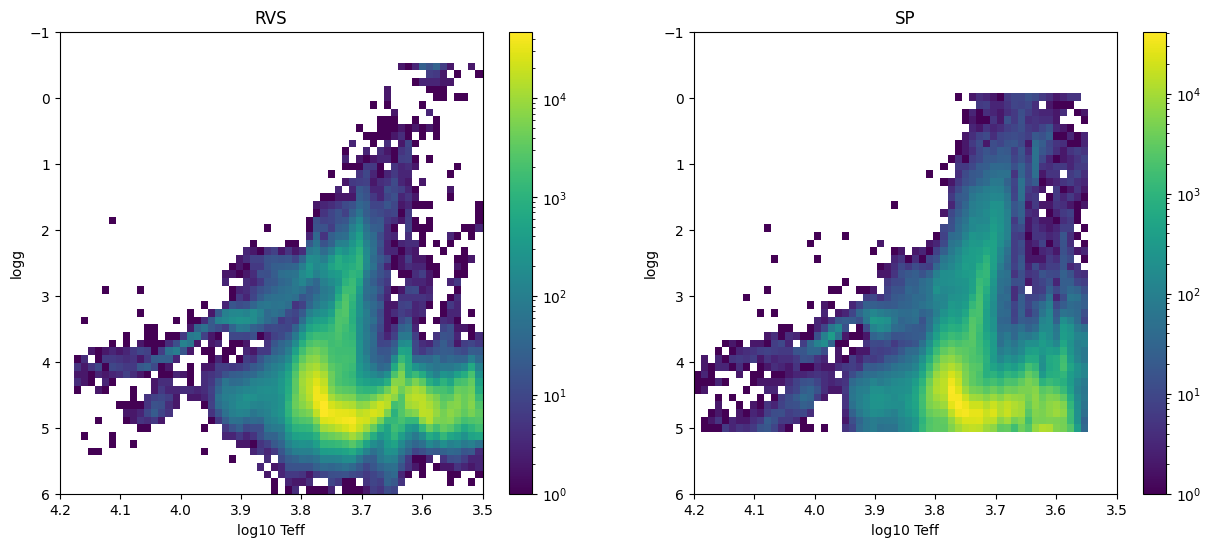

In [13]:
import matplotlib.colors as maco

cur_sel = main_sel & (RV_T['SURVEY'] == 'main') & (
    RV_T['PROGRAM'] == 'bright') & (RV_T['SN_R'] > 10) & (RV_T['VSINI']<30)
plt.figure(1, figsize=(15, 6))
plt.subplot(121)
plt.hist2d(np.log10(RV_T['TEFF'][cur_sel]),
           RV_T['LOGG'][cur_sel],
           range=[[3.5, 4.2], [-1, 6]],
           bins=[60, 60],
           norm=maco.LogNorm())
plt.xlim(4.2, 3.5)
plt.ylim(6, -1)
plt.xlabel('log10 Teff')
plt.ylabel('logg')
plt.title('RVS')
plt.colorbar()

plt.subplot(122)
cur_sel = main_sel & (RV_T['SURVEY'] == 'main') & (
    RV_T['PROGRAM'] == 'bright') & (SP_T['SUCCESS'] == 1) & (SP_T['BESTGRID']!='s_rdesi1')
plt.hist2d(np.log10(SP_T['TEFF'][cur_sel]),
           SP_T['LOGG'][cur_sel],
           range=[[3.5, 4.2], [-1, 6]],
           bins=[60, 60],
           norm=maco.LogNorm())
plt.xlim(4.2, 3.5)
plt.ylim(6, -1)
plt.xlabel('log10 Teff')
plt.ylabel('logg')
plt.title('SP')
plt.colorbar()

# Abundances 

[Fe/H] and [a/Fe] distribution

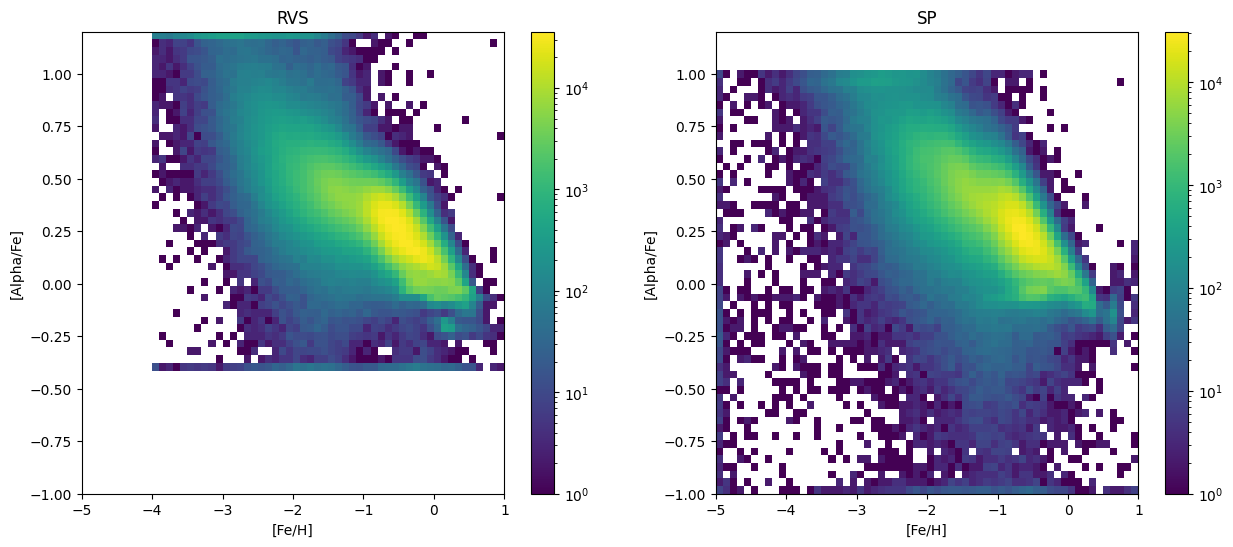

In [14]:
cur_sel = main_sel & (RV_T['SURVEY'] == 'main') & (
    RV_T['PROGRAM'] == 'bright') & (RV_T['SN_R'] > 10) & (RV_T['VSINI']<30)
plt.figure(1, figsize=(15, 6))
plt.subplot(121)
plt.hist2d(RV_T['FEH'][cur_sel],
           RV_T['ALPHAFE'][cur_sel],
           range=[[-5, 1], [-1, 1.2]],
           bins=[60, 60],
           norm=maco.LogNorm())
plt.xlabel('[Fe/H]')
plt.ylabel('[Alpha/Fe]')
plt.title('RVS')
plt.colorbar()

plt.subplot(122)
cur_sel = main_sel & (RV_T['SURVEY'] == 'main') & (
    RV_T['PROGRAM'] == 'bright') & (SP_T['SUCCESS'] == 1)  & (SP_T['BESTGRID']!='s_rdesi1')
plt.hist2d(SP_T['FEH'][cur_sel],
           SP_T['ALPHAFE'][cur_sel],
           range=[[-5, 1], [-1, 1.2]],
           bins=[60, 60],
           norm=maco.LogNorm())
plt.xlabel('[Fe/H]')
plt.ylabel('[Alpha/Fe]')
plt.title('SP')
plt.colorbar()

# Metallicity distribution

here we show the distribution of iron abundances in the main survey 
as measured by two stellar pipeline RV and SP.

We also restrict the sample by the effective temperature from 4500 to 7000 K 


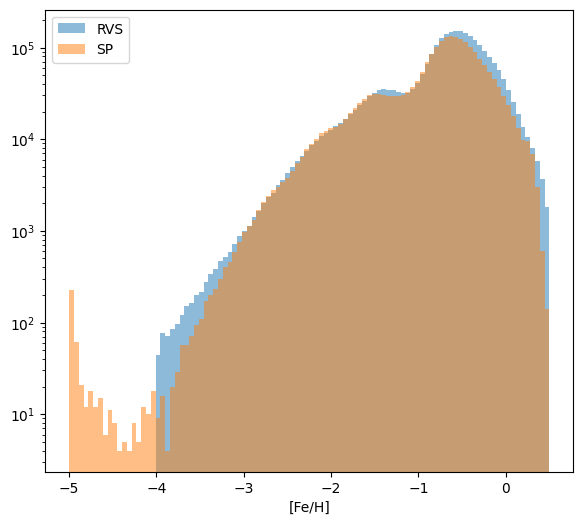

In [21]:


min_teff= 4500
max_teff= 7000
cur_sel = (main_sel & (RV_T['SURVEY'] == 'main') & (RV_T['SN_R'] > 10) & 
           (RV_T['TEFF']>min_teff) & (RV_T['TEFF']<max_teff) & (RV_T['VSINI']<30))
                                                                                                                   
plt.figure(1, figsize=(15, 6))
plt.subplot(121)
plt.hist(RV_T['FEH'][cur_sel], range=[-5, .5], label='RVS', alpha=.5, bins=100)
plt.xlabel('[Fe/H]')
cur_sel = (main_sel & (RV_T['SURVEY'] == 'main') & (RV_T['SN_R'] > 10) & 
           (SP_T['BESTGRID']!='s_rdesi1')& (SP_T['TEFF']>min_teff) & (SP_T['TEFF']<max_teff))
plt.hist(SP_T['FEH'][cur_sel], range=[-5, .5], label='SP', alpha=.5, bins=100)
plt.gca().set_yscale('log')
plt.legend()

# Chemo-dynamics with DESI

Here we just make some basic plots using Gaia's parallax as a distance
For this data release however, the spectro-photometric distances are also available 
See https://data.desi.lbl.gov/doc/releases/dr1/vac/


In [29]:
dist = 1./G_T['PARALLAX']
dist[(dist<0)]=np.nan
C=acoo.SkyCoord(ra=RV_T['TARGET_RA']*auni.deg,
                dec=RV_T['TARGET_DEC']*auni.deg,
                distance=dist*auni.kpc,
                pm_ra_cosdec=G_T['PMRA']*auni.mas/auni.year,
                pm_dec=G_T['PMDEC']*auni.mas/auni.year,
                radial_velocity=RV_T['VRAD'])
Cg=C.transform_to(acoo.Galactocentric);
Cs=Cg.represent_as(acoo.SphericalRepresentation);
Cc=Cg.represent_as(acoo.CylindricalRepresentation);
Vphi=(Cc.differentials['s'].d_phi*Cc.rho/auni.rad).to_value(auni.km/auni.s)
Vpsi=(Cs.differentials['s'].d_lat*Cc.rho/auni.rad).to_value(auni.km/auni.s)
VR=Cs.differentials['s'].d_distance.to_value(auni.km/auni.s);
R=Cs.distance.to_value(auni.kpc);
LZ=(Vphi*Cc.rho).to_value(auni.kpc)

# Gaia phase-space spiral

<>:10: SyntaxWarning: invalid escape sequence '\p'
<>:10: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_1189229/3701541053.py:10: SyntaxWarning: invalid escape sequence '\p'
  plt.colorbar(label='V$_\phi$ [km/s]')


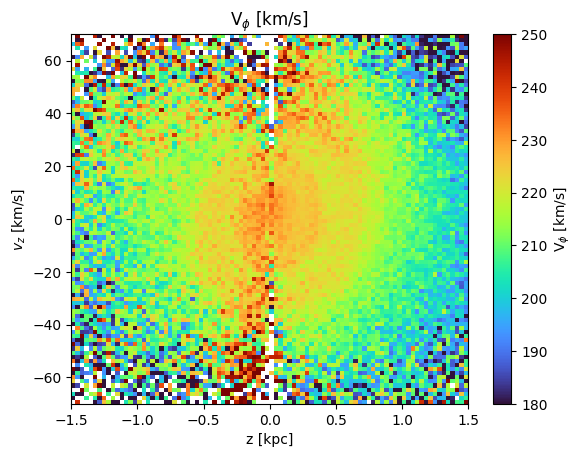

In [55]:
cur_sel = main_sel&(G_T['PARALLAX']>3*G_T['PARALLAX_ERROR']) &(RV_T['FEH']>-0.2)
S = scipy.stats.binned_statistic_2d(Cg.z[cur_sel],Cg.v_z[cur_sel],Vphi[cur_sel],'median',range=[[-1.5,1.5],[-70,70]],
                                   bins=[90,90])

plt.imshow(-S.statistic.T, extent=(-1.5,1.5,-70,70), origin='lower',cmap='turbo',aspect='auto',vmin=180,vmax=250)

plt.xlabel('z [kpc]')
plt.ylabel(r'$v_z$ [km/s]')
plt.title(r'V$_\phi$ [km/s]')
plt.colorbar(label='V$_\phi$ [km/s]')

# Gaia-Encelladus-Sausage

Here we plot VR vs Vphi inthe solar-neighborhood to show the GSE radially biased orbits for the metallicity range around [Fe/H]=-1.2


Text(0.5, 0, 'V$_R$ [km/s]')

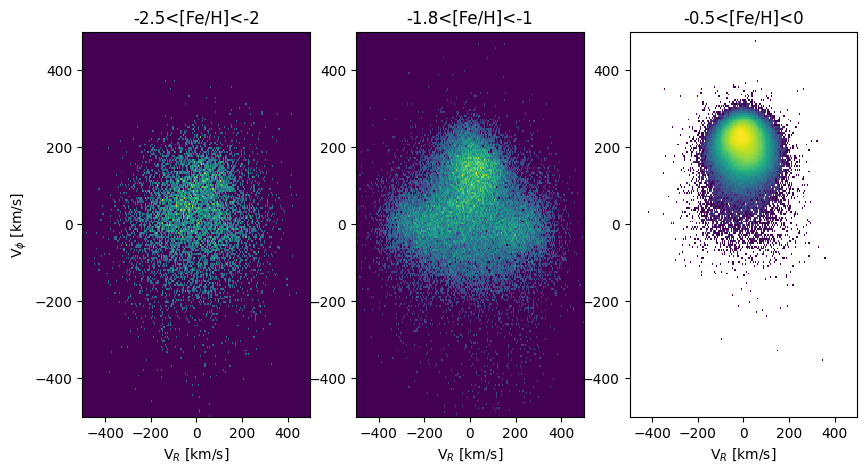

In [57]:

cur_sel = (main_sel&(G_T['PARALLAX']>5*G_T['PARALLAX_ERROR']) &(RV_T['FEH']>-2.5)&(RV_T['FEH']<-2) & 
betw(RV_T['TEFF'],4500,7000) & (RV_T['VSINI']<30))
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.hist2d(VR[cur_sel], -Vphi[cur_sel],range=[[-500,500],[-500, 500]],bins=[200,200], norm=maco.PowerNorm(gamma=.5));
plt.title('-2.5<[Fe/H]<-2')
plt.xlabel('V$_R$ [km/s]')
plt.ylabel(r'V$_\phi$ [km/s]')

cur_sel = (main_sel&(G_T['PARALLAX']>5*G_T['PARALLAX_ERROR']) &(RV_T['FEH']>-1.8)&(RV_T['FEH']<-1.2) & 
betw(RV_T['TEFF'],4500,7000) & (RV_T['VSINI']<30))

plt.subplot(1,3,2)
plt.hist2d(VR[cur_sel], -Vphi[cur_sel],range=[[-500,500],[-500, 500]],bins=[200,200], norm=maco.PowerNorm(gamma=.5));
plt.title('-1.8<[Fe/H]<-1')
plt.xlabel('V$_R$ [km/s]')

cur_sel = (main_sel&(G_T['PARALLAX']>5*G_T['PARALLAX_ERROR']) &(RV_T['FEH']>-0.5)&(RV_T['FEH']<0) & 
betw(RV_T['TEFF'],4500,7000) & (RV_T['VSINI']<30))

plt.subplot(1,3,3)
plt.hist2d(VR[cur_sel], -Vphi[cur_sel],range=[[-500,500],[-500, 500]],bins=[200,200], norm=maco.LogNorm());
plt.title('-0.5<[Fe/H]<0')
plt.xlabel('V$_R$ [km/s]')


# Single epoch data

Here we look at the single epoch measurements just in the one one survey/program sv3/bright

In [66]:
T_RV1 = atpy.Table().read('data/rvpix_exp-sv3-bright.fits','RVTAB', mask_invalid=False)
T_FM1 = atpy.Table().read('data/rvpix_exp-sv3-bright.fits','FIBERMAP', mask_invalid=False)
T_G1 = atpy.Table().read('data/rvpix_exp-sv3-bright.fits',"GAIA", mask_invalid=False)


Now we just look at one object with source_id=3698465917056207872  that is an RR Lyrae star. 
We show its radial velocity curve and show it folded with the Gaia DR3 period

(0.0, 2.0)

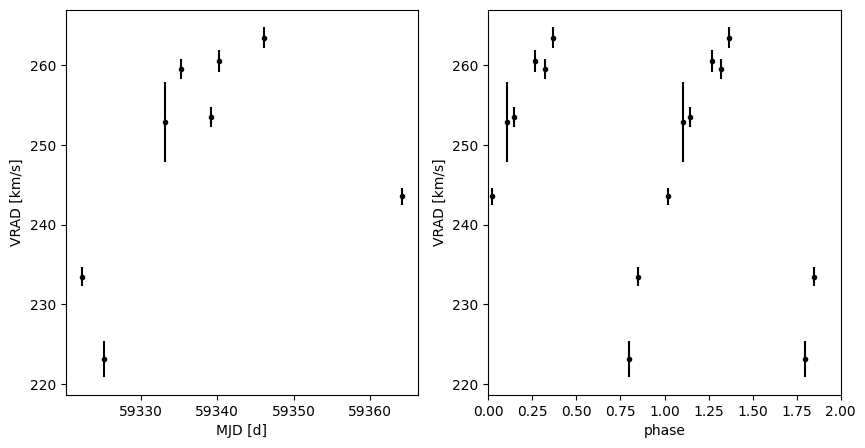

In [80]:
rrl = T_G1['SOURCE_ID']== 3698465917056207872
rrl.sum()
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.errorbar(T_FM1['MJD'][rrl],T_RV1['VRAD'][rrl],T_RV1['VRAD_ERR'][rrl],fmt='k.')
plt.xlabel('MJD [d]')
plt.ylabel('VRAD [km/s]')
period= 0.49197089  # from Gaia DR3

plt.subplot(1,2,2)
plt.errorbar((T_FM1['MJD'][rrl]%period)/period,T_RV1['VRAD'][rrl],T_RV1['VRAD_ERR'][rrl],fmt='k.')
plt.errorbar((T_FM1['MJD'][rrl]%period)/period+1,T_RV1['VRAD'][rrl],T_RV1['VRAD_ERR'][rrl],fmt='k.')
plt.xlabel('phase')
plt.ylabel('VRAD [km/s]');
plt.xlim(0,2)